# ⚛️ H₂ VQE — Ansatz Comparison (Noiseless)

This notebook compares **different variational ansätze** for ground-state VQE.
It consists of two intentionally different parts:

---
## 🧩 Part A — Educational Toy Ansätze (Manual VQE)

This section:
- defines simple pedagogical ansätze inside this notebook
- uses tiny circuits to teach expressivity and circuit structure
- runs manual optimisation loops

These toy circuits are not meant to match the production ansätze used by the package.

---
## 🟦 Part B — Production-Level Ansatz Comparison

This section uses:

```python
from vqe.core import run_vqe_ansatz_comparison
```

and evaluates package-defined ansätze with caching + reproducibility.

# 🧩 Part A — Educational (Manual) Ansatz Comparison

In [12]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

seed = 0
np.random.seed(seed)

## Step 1 — Build Hamiltonian (manual, educational)

In [13]:
sym = ["H", "H"]
coords = np.array(
    [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.7414],
    ]
)
basis = "STO-3G"

H, num_qubits = qchem.molecular_hamiltonian(sym, coords, basis=basis, unit="Angstrom")

backend = "default.qubit"  # keep explicit, but avoid literal in qml.device("...")
dev = qml.device(backend, wires=num_qubits)

print("Number of qubits:", num_qubits)

Number of qubits: 4


## Step 2 — Define Toy Ansätze

Simple, interpretable, low-depth circuits.
Names are prefixed with **Toy-** to avoid confusion with package ansätze.

In [14]:
def toy_minimal(params, wires):
    """Toy 2-qubit minimal entangler."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])


def toy_ry_cz(params, wires):
    """Toy RY layer + CZ entangler (full wires)."""
    for i, w in enumerate(wires):
        qml.RY(params[i], wires=w)
    qml.CZ(wires=[wires[0], wires[1]])


def toy_two_qubit_ry_cnot(params, wires):
    """Toy expressive 2-qubit circuit."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(-params[0], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


toy_ansatzes = {
    "Toy-Minimal": toy_minimal,
    "Toy-RY-CZ": toy_ry_cz,
    "Toy-TwoQubit-RY-CNOT": toy_two_qubit_ry_cnot,
}

## Step 3 — Build cost functions

In [15]:
def make_cost(ansatz_fn):
    @qml.qnode(dev)
    def cost(params):
        ansatz_fn(params, wires=range(num_qubits))
        return qml.expval(H)

    return cost

## Step 4 — Run manual VQE loops (Adam)

Educational only: no caching, no molecule helpers, no package engines.

In [16]:
from vqe.optimizer import get_optimizer

steps = 75
stepsize = 0.2
results_A = {}

for name, fn in toy_ansatzes.items():
    num_params = num_qubits if name == "Toy-RY-CZ" else 1

    print(f"\nRunning educational VQE with ansatz = {name}")
    params = 0.05 * np.random.randn(num_params, requires_grad=True)
    opt = get_optimizer("Adam", stepsize)

    cost = make_cost(fn)
    energies = []

    for _ in range(steps):
        params, prev = opt.step_and_cost(cost, params)
        energies.append(float(prev))

    results_A[name] = {"energies": energies, "params": params}


Running educational VQE with ansatz = Toy-Minimal

Running educational VQE with ansatz = Toy-RY-CZ

Running educational VQE with ansatz = Toy-TwoQubit-RY-CNOT


## Step 5 — Plot toy convergence curves

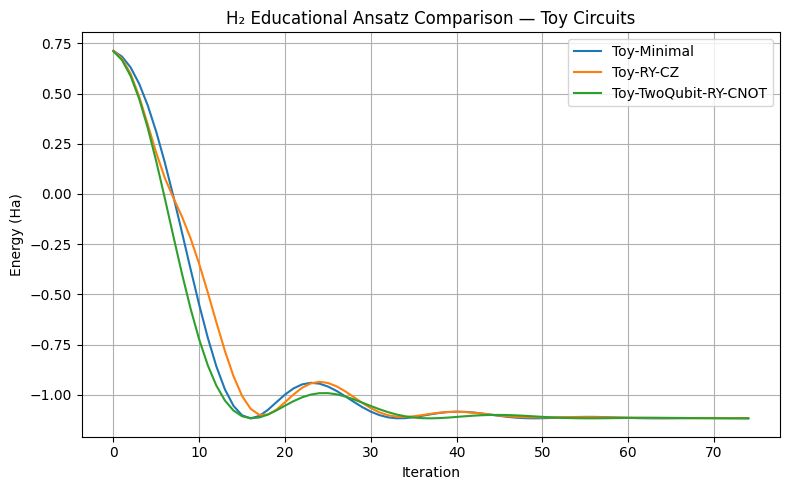

In [17]:
plt.figure(figsize=(8, 5))
for name, data in results_A.items():
    plt.plot(data["energies"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ Educational Ansatz Comparison — Toy Circuits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 6 — Draw toy circuits


Toy-Minimal circuit:


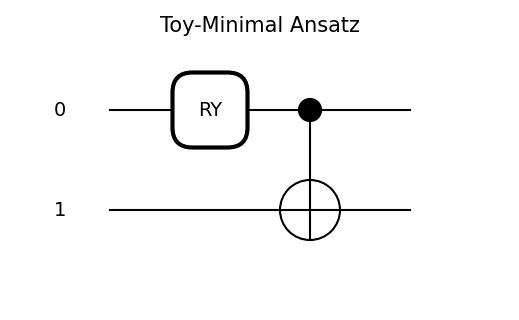


Toy-RY-CZ circuit:


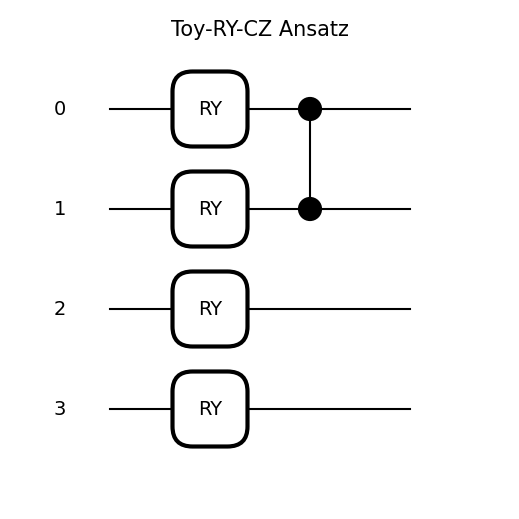


Toy-TwoQubit-RY-CNOT circuit:


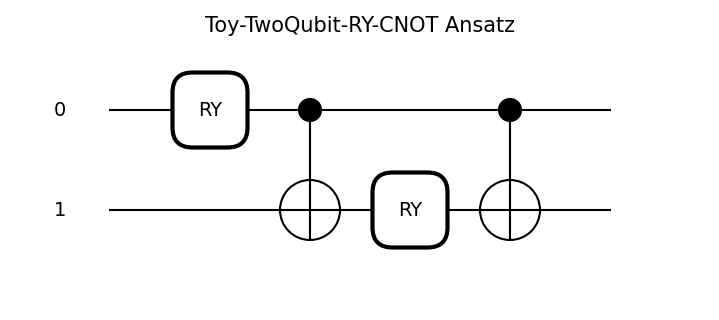

In [18]:
for name, fn in toy_ansatzes.items():
    params = results_A[name]["params"]
    print(f"\n{name} circuit:")
    fig, ax = qml.draw_mpl(fn)(params, wires=range(num_qubits))
    fig.suptitle(f"{name} Ansatz", fontsize=15)
    plt.show()

# 🟦 Part B — Production-Level Ansatz Comparison

Uses `run_vqe_ansatz_comparison(...)` for package-defined ansätze.

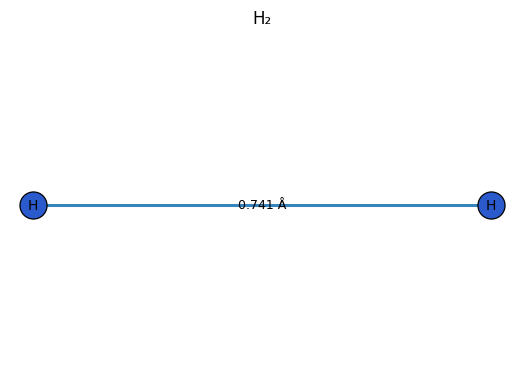

In [19]:
from common.molecule_viz import plot_molecule

plot_molecule(
    sym,
    coords,
    title="H₂",
    bonds=[(0, 1)],
    angles=[],
    show_bond_lengths=True,
    show_atom_indices=False,
)
plt.show()


🔹 Running ansatz: Minimal

🔹 Running ansatz: RY-CZ

🔹 Running ansatz: TwoQubit-RY-CNOT


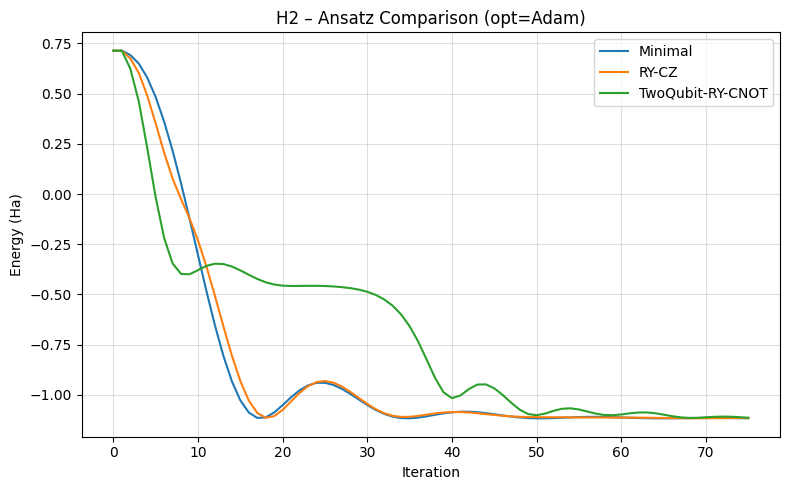

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/ansatz_conv_Adam_s0.png


In [20]:
from vqe.core import run_vqe_ansatz_comparison

results_B = run_vqe_ansatz_comparison(
    molecule="H2",
    optimizer_name="Adam",
    ansatzes=["Minimal", "RY-CZ", "TwoQubit-RY-CNOT"],
    steps=75,
    stepsize=0.2,
    noisy=False,
    seed=int(seed),
)